# Solid dosage forms dissolution models

Immediate or extended release drug product are characterized by their Active Pharmaceutical Ingredient (API) dissolution profile, tested according to USP <711> or Ph. Eur. 2.9.3 monographs.

Several models have been proposed to fit the dissolution profile across time, $y(t)$:
* **Weibull Model** based on diffusion: $y(t) = p(1-e^{-zt})$

where $p$ is a *potency factor* (= dissolution plateau fraction value, set to 1 if the total quantity of API is released) and $z$ is a *kinetic dissolution factor* (higher $z$, faster dissolution).


* **Modified Weibull Model**: $y(t) = p(1-e^{(-zt)^k})$

which introduces an additional *scale factor* $k$, meant to better fit experimentally observed dissolution profiles.


* **Noyes-Whitney Model** expressed by the differential equation: $\frac{dy(t)}{dt} = z(p-y(t))^n (s-y(t)\frac{dose}{v})$

which considers the effect of the API concentration gradient during the dissolution through the term $(s-y(t)\frac{dose}{v})$, where $s$ is the *API solubility* in the dissolution media, $dose$ is the *API dose* in the drug dosage form and $v$ is the *volume* of dissolution media. $n$ is a *shape factor* controlling the dissolution profile.



# Imports

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Functions

In [2]:
# Define dissolution profile, expressed as differential equation
def dydt(t, y, z, p, n, s, dose, v):
    """Define dissolution profile, expressed as differential equation.

    Args:
        t (float): time
        y (float): fraction of dissolved API
        z (float): kinetic dissolution factor
        p (float): potency factor (= dissolution plateau reached at the end)
        n (float): dissolution profile shape factor
        s (float): API solubility in dissolution media
        dose (float): API quantity in dosage unit
        v (float): volume of dissolution media

    Returns:
        float: dy/dt value at time t
    """
    return z * (p - y)**n * (s - y * dose / v)

# Function to solve the ODE with given parameters z and n
def solve_ode(z, n, p, s, dose, v, y0, t_eval):
    """_summary_

    Args:
        z (float): kinetic dissolution factor
        n (float): dissolution profile shape factor
        p (float): potency factor (= dissolution plateau reached at the end)
        s (float): API solubility in dissolution media
        dose (float): API quantity in dosage unit
        v (float): volume of dissolution media
        y0 (float): API dissolved fraction at t=0 (generally 0)
        t_eval (ndarray or list): time points at which to store the solution

    Returns:
        float: vector of calculated dissolution fractions at t_eval timepoints (or vector of np.nan if no solution found)
    """
    sol = solve_ivp(dydt, (t_eval[0], t_eval[-1]), [y0], args=(z, p, n, s, dose, v), t_eval=t_eval, method='RK45')
    if sol.success and len(sol.y[0]) == len(t_eval):
        return sol.y[0]  # Return only the y values if the solution is successful and matches t_eval length
    else:
        # Return an array of NaNs if the solution fails to avoid shape mismatches in objective function
        return np.full_like(t_eval, np.nan)

# Objective function to minimize the difference between ODE solution and experimental data
def objective(params, t_data, y_data, p, s, dose, v, y0):
    """Least squares objective function to minimize in order to fit parameters z and n.

    Args:
        params (tuple): paramter to fit (z, n)
        t_data (ndarray or list): empirical time points for which dissolution profile has been measured
        y_data (ndarray or list): measured dissolution profile
        p (float): potency factor (= dissolution plateau reached at the end)
        s (float): API solubility in dissolution media
        dose (float): API quantity in dosage unit
        v (float): volume of dissolution media
        y0 (float): API dissolved fraction at t=0 (generally 0)

    Returns:
        float: value of objective function
    """
    z, n = params  # Unpack parameters
    y_model = solve_ode(z, n, p, s, dose, v, y0, t_data)  # Solve ODE with current parameters
    if np.isnan(y_model).any():  # Check if the solution failed
        return np.inf  # Return a large value if the ODE solver failed
    return np.sum((y_data - y_model)**2)  # Calculate the sum of squared differences

# Main

## Modelling dissolution profile, expressed with differential equation

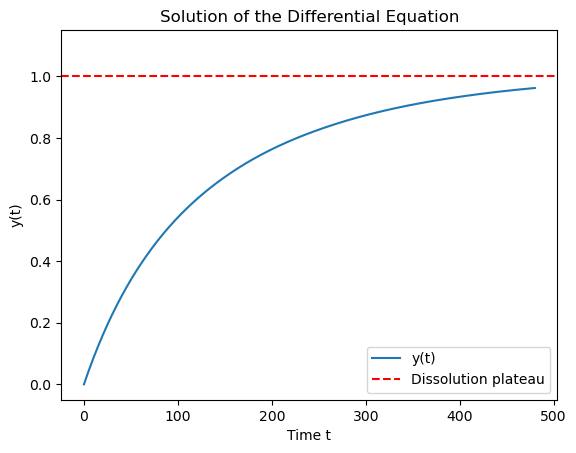

In [14]:
# Parameters and initial conditions
z = 0.012
p = 1.0
n = 0.75
s =  0.75
dose = 0.5
v = 1
y0 = 0   # Initial value of y at t = 0

# Solve the ODE
t_span = (0, 480)  # Time range to solve over (e.g., from t=0 to t=300)
t_eval = np.linspace(t_span[0], t_span[1], t_span[1]+1)  # Points at which to store the solution
sol = solve_ivp(dydt, t_span, [y0], args=(z, p, n, s, dose, v), t_eval=t_eval, method='RK45')

# Plot the solution
plt.plot(sol.t, sol.y[0], label='y(t)')
plt.axhline(y=p, color='red', linestyle='--', label='Dissolution plateau')
plt.xlabel('Time t')
plt.ylabel('y(t)')
plt.ylim([-.05, 1.15])
plt.title('Solution of the Differential Equation')
plt.legend(loc='lower right')
plt.show()

## Defining experimental dissolution profile

In [23]:
# Time points for which dissolution values are measured
t_data = np.array([0, 90, 240, 270])

# Measured sissolution values
y_data = sol.y[0][np.where(np.isin(sol.t, [0, 90, 240, 270]))] * np.random.default_rng().normal(1, 0.05, 4)

print("Empirical dissolution profile:\n",
      np.vstack((t_data, np.round(y_data, 3))))


Empirical dissolution profile:
 [[  0.     90.    240.    270.   ]
 [  0.      0.5     0.849   0.833]]


## Fitting dissolution profile based on empirical dissolution profile

C:\Users\SamdGuizani\AppData\Local\Temp\ipykernel_11020\3066802375.py:18: RuntimeWarning: invalid value encountered in power
  return z * (p - y)**n * (s - y * dose / v)


Optimal parameters: z = 0.012, n = 0.68


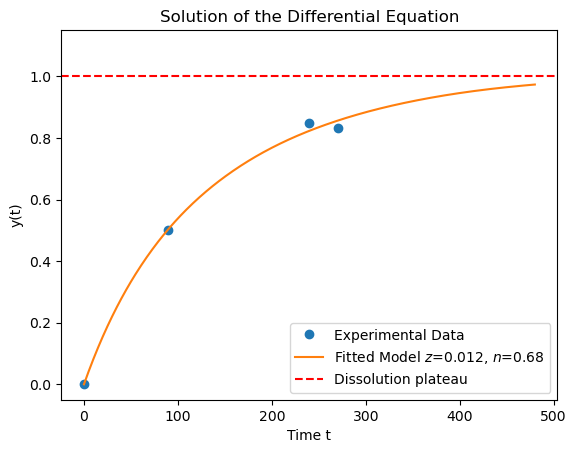

In [24]:
# Known parameters and initial condition
# z     # Unknown parameter to fit
p = 1.0
# n     # Unknown parameter to fit
s =  0.75
dose = 0.5
v = 1
y0 = 0  # Initial condition for y

# Initial guess for parameters z and n
initial_guess = [0.01, 1.0]

# Perform the optimization
result = minimize(objective, initial_guess, args=(t_data, y_data, p, s, dose, v, y0), bounds=[(0, None), (0, None)])
z_opt, n_opt = result.x

# Print the fitted parameters
print(f"Optimal parameters: z = {z_opt:.3f}, n = {n_opt:.2f}")

# Solve the ODE using the optimized parameters
t_span = (0, 480)  # Time range to solve over (e.g., from t=0 to t=300)
t_eval = np.linspace(t_span[0], t_span[1], t_span[1]+1)  # Points at which to store the solution
y_fitted = solve_ode(z_opt, n_opt, p, s, dose, v, y0, t_eval)

# Plot the data
plt.plot(t_data, y_data, 'o', label='Experimental Data')
plt.plot(t_eval, y_fitted, '-', label=f'Fitted Model $z$={z_opt:.3f}, $n$={n_opt:.2f}')
plt.axhline(y=p, color='red', linestyle='--', label='Dissolution plateau')
plt.xlabel('Time t')
plt.ylabel('y(t)')
plt.ylim([-.05, 1.15])
plt.title('Solution of the Differential Equation')
plt.legend(loc='lower right')
plt.show()